# This notebook submits results to the DPhi challenge: https://dphi.tech/challenges/data-sprint-92-telescope-spectrum-classification/297/overview/about

# Methodology:
1.

In [2]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
os.environ['PYTHONHASHSEED'] = str(1)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
random.seed(1)
np.random.seed(1)
# tf.random.set_seed(1)
tf.compat.v1.set_random_seed(1)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
# from tqdm import tqdm
# import tensorflow_addons as tfa
import gc

In [7]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score as acc, classification_report as cr, ConfusionMatrixDisplay as cm
from sklearn.metrics import precision_score as ps, recall_score as rs, f1_score as f1
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
import time
from imblearn.over_sampling import SMOTE

### Declare the path

In [8]:
train_path = '/home/sandeep/Development/Datasets/Climate/dphi_ds92_Telescope_Spectrum_Classification/data/train_dataset.csv'
test_path = '/home/sandeep/Development/Datasets/Climate/dphi_ds92_Telescope_Spectrum_Classification/data/test_dataset.csv'

### Read the csv datasets into pandas dataframes

In [9]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
display(train_df.head(1))
display(test_df.head(1))

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,20.1426,9.9778,2.2695,0.6022,0.3898,-4.7403,15.5312,-9.5154,17.646,56.5999,g


,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
0,20.0335,14.284,2.4378,0.5328,0.2719,4.5573,-13.3556,3.5595,30.2511,173.673


In [10]:
train_df['class'] = train_df['class'].map({'g':1, 'h':0})

In [11]:
train_df.describe()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,52.994803,22.054462,2.819959,0.381813,0.215697,-4.931682,10.383390,0.304136,27.891382,193.044959,0.644400
std,42.849736,18.197425,0.473256,0.184880,0.111944,59.224209,51.401824,20.469221,26.194761,73.617054,0.478743
min,8.230400,0.000000,2.006500,0.013100,0.000300,-378.945700,-297.171700,-134.395000,0.000000,5.699800,0.000000
25%,24.209800,11.856275,2.471950,0.232775,0.127000,-20.685800,-12.849600,-10.779250,5.671400,142.300500,0.000000
50%,36.921900,17.029450,2.730500,0.355550,0.197600,3.472900,15.191900,0.000050,18.167900,192.861500,1.000000
75%,68.778050,24.525525,3.094100,0.508725,0.288950,23.336200,34.561725,10.854250,46.956725,239.579850,1.000000
max,334.177000,201.364000,5.323300,0.875700,0.675200,473.065400,238.321000,163.269700,90.000000,466.407800,1.000000


# Separate into dependent and independent features

In [116]:
train_X = train_df.drop('class', axis=1).copy()
train_y = train_df['class'].copy()
final_X = test_df.copy()

# Visualize the data

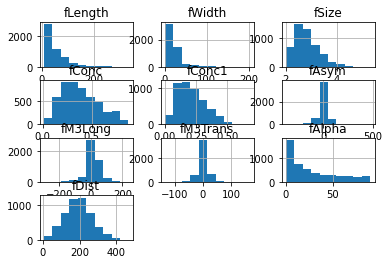

In [109]:
train_X.hist()
plt.show()

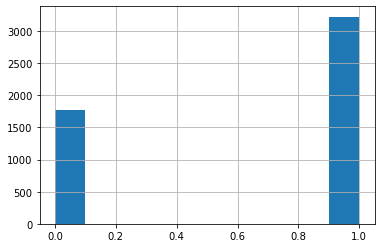

In [110]:
train_y.hist()
plt.show()

# The target classes are imbalanced, positive gamma cases are double of that of background

# Let's balance the data by carrying out minority oversampling

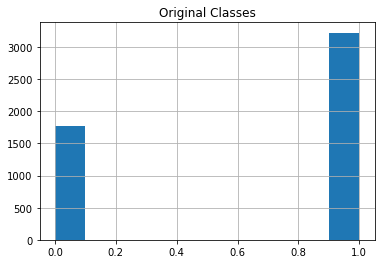

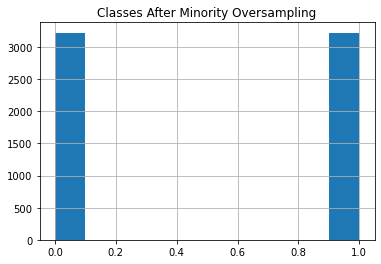

In [111]:
train_y.hist()
plt.title('Original Classes')
plt.show()
sm = SMOTE()
train_X, train_y = sm.fit_resample(train_X, train_y)
y.hist()
plt.title('Classes After Minority Oversampling')
plt.show()

# Loss and Metric Plotting Functions

In [118]:
start = 1
def plot_loss(history_dict):
    key1 = list(history_dict.keys())[0]
    key2 = list(history_dict.keys())[2]
    loss_values = history_dict[key1][start:]
    val_loss_values=history_dict[key2][start:]
    plt.plot(loss_values,'b-',label=key1)
    plt.plot(val_loss_values,'r--',label=key2)
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.show()
    print(key1, ': ', history_dict[key1][-1], key2,': ', history_dict[key2][-1])

def plot_metric(history_dict):
    key1 = list(history_dict.keys())[1]
    key2 = list(history_dict.keys())[3]
    metric_values = history_dict[key1][start:]
    val_metric_values=history_dict[key2][start:]
    plt.plot(metric_values,'b-',label=key1)
    plt.plot(val_metric_values,'r--',label=key2)
    plt.title('Training vs Validation Metric')
    plt.legend()
    plt.show()
    print(key1, ': ', history_dict[key1][-1], key2,': ', history_dict[key2][-1])

In [113]:
train_X.shape

(6444, 10)

# Neural Network

Epoch 1/100
14/14 [==============================] - 4s 179ms/step - loss: 27.5598 - accuracy: 0.5007 - val_loss: 0.5588 - val_accuracy: 0.7113
Epoch 2/100
14/14 [==============================] - 2s 128ms/step - loss: 0.5474 - accuracy: 0.7249 - val_loss: 0.5238 - val_accuracy: 0.7527
Epoch 3/100
14/14 [==============================] - 2s 144ms/step - loss: 0.5341 - accuracy: 0.7442 - val_loss: 0.4822 - val_accuracy: 0.7760
Epoch 4/100
14/14 [==============================] - 2s 134ms/step - loss: 0.5005 - accuracy: 0.7677 - val_loss: 0.4874 - val_accuracy: 0.7853
Epoch 5/100
14/14 [==============================] - 2s 140ms/step - loss: 0.4980 - accuracy: 0.7684 - val_loss: 0.4506 - val_accuracy: 0.8067
Epoch 6/100
14/14 [==============================] - 2s 141ms/step - loss: 0.4827 - accuracy: 0.7767 - val_loss: 0.4575 - val_accuracy: 0.7787
Epoch 7/100
14/14 [==============================] - 2s 150ms/step - loss: 0.4705 - accuracy: 0.7749 - val_loss: 0.4441 - val_accuracy: 0.794

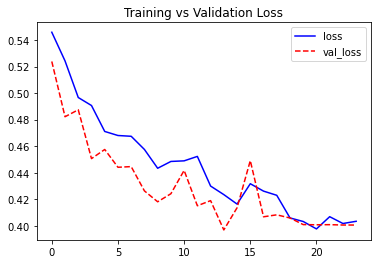

loss :  0.40341028571128845 val_loss :  0.40059155225753784


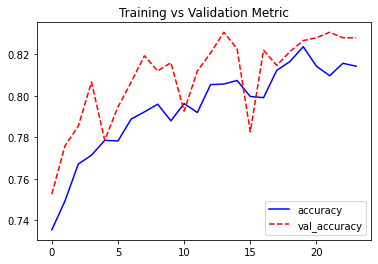

accuracy :  0.8142856955528259 val_accuracy :  0.828000009059906


In [183]:
activation='relu'
model = Sequential([
    Dense(units=512, input_shape=(10,), activation=activation),
    Dropout(0.4),
    Dense(units=512, activation=activation),
    Dense(units=256, activation=activation),
    Dense(units=256, activation=activation),
    Dense(units=128, activation=activation),
    Dense(units=64, activation=activation),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
lr_call = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, verbose=0, mode="min", cooldown=0, min_lr=0)
stop_call = EarlyStopping(monitor='val_loss', patience=10, verbose=10)
history = model.fit(x=train_X, y=train_y, validation_split=0.3, batch_size=256, shuffle=True, epochs=100, 
                    verbose=1, callbacks=[stop_call, lr_call]#,  class_weight=({0:1.4,1:0.7}), 
                   )
plot_loss(history.history)
plt.show()
plot_metric(history.history)
plt.show()

In [184]:
preds = model.predict(train_X).reshape(-1,)
preds = (preds>0.5).astype(int)
preds

array([1, 1, 0, ..., 0, 1, 1])

# Confusion Matrix

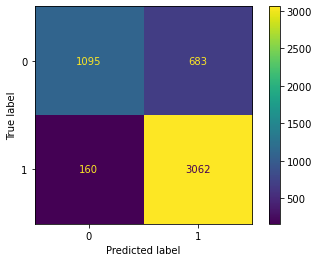

In [185]:
cm.from_predictions(train_y, preds)
plt.show()

# Classification Report

In [186]:
print(cr(train_y,preds))

              precision    recall  f1-score   support

           0       0.87      0.62      0.72      1778
           1       0.82      0.95      0.88      3222

    accuracy                           0.83      5000
   macro avg       0.85      0.78      0.80      5000
weighted avg       0.84      0.83      0.82      5000



# Predictions

In [195]:
preds = model.predict(final_X.iloc[:,:10])
preds = (preds>0.5).astype(int)
final_X['preds'] = preds
final_X['class'] = final_X['preds'].map({1:'g', 0:'h'})
final_X['class'].to_csv('/home/sandeep/Development/Datasets/Climate/dphi_ds92_Telescope_Spectrum_Classification/submission/sub3.csv', 
                   index=False)

In [197]:
d1 = pd.read_csv('/home/sandeep/Development/Datasets/Climate/dphi_ds92_Telescope_Spectrum_Classification/submission/sub1.csv')
d2 = pd.read_csv('/home/sandeep/Development/Datasets/Climate/dphi_ds92_Telescope_Spectrum_Classification/submission/sub3.csv')

In [229]:
d3 = d1+d2
d3.head()

,class
0,gg
1,gg
2,gg
3,hh
4,hh


In [230]:
d3['class'] = d3['class'].apply(lambda x: 'g' if x=='gg' or x=='gh' else 'h')
d3['class'].to_csv('/home/sandeep/Development/Datasets/Climate/dphi_ds92_Telescope_Spectrum_Classification/submission/sub4.csv', 
                   index=False)

In [231]:
(d3!=d1).astype(int).sum()

class    0
dtype: int64